## Anomaly Detection

In [35]:
%matplotlib inline
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras import backend as K
from keras.models import Model
from keras.layers import Activation, BatchNormalization
from keras.layers import Dropout, Dense, Input, LSTM
from keras.optimizers import Adam

Reading data from https://github.com/numenta/NAB/tree/master/data. The data is about the number of tweets by Amazon every 5 minutes.

In [36]:
data = pd.read_csv('https://raw.githubusercontent.com/numenta/NAB/master/data/realTweets/Twitter_volume_AMZN.csv')
data.shape

(15831, 2)

Text(0.5, 1.0, 'Plot the Original data')

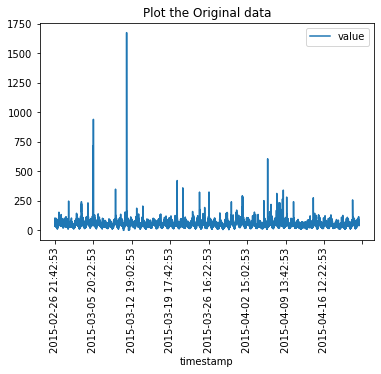

In [62]:
data.set_index('timestamp').plot()
plt.xticks(rotation='vertical')
plt.title("Plot the Original data")

Splitting the data into test and validation. We attempt to predict the next 5 values based on the data from the previous day.

In [38]:
from sklearn.model_selection import train_test_split

X = data['value'].values.reshape((len(data), 1))
y = data['value'].values.reshape((len(data), 1))

X = X[:-1, :]
y = y[1:, :]

# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = X[:int(len(X)*0.9)], X[int(len(X)*0.9):], y[:int(len(y)*0.9)], y[int(len(y)*0.9):]

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((14247, 1), (14247, 1), (1583, 1), (1583, 1))

In [39]:
n_timesteps = 144
n_samples = X_train.shape[0]
n_features = X_train.shape[1]
n_val_samples = X_val.shape[0]
k=-5
batch_size=128
epochs=50


In [40]:
X_train_list = [np.expand_dims(X_train[i-n_timesteps:i, :], axis=0) for i in range(n_timesteps, n_samples+1)]
X_train_list = X_train_list[:k]
X_train = np.concatenate(X_train_list, axis=0)
y_train_list = [np.expand_dims(y_train[i:i+5, :], axis=0) for i in range(n_timesteps, n_samples -5 + 1)]
y_train = np.concatenate(y_train_list, axis=0)
X_train = X_train[:-1, :, :]
y_train = y_train[1:, :, :]
# y_train = y_train[n_timesteps-1:, :]


X_val_list = [np.expand_dims(X_val[i-n_timesteps:i, :], axis=0) for i in range(n_timesteps, n_val_samples + 1)]
X_val_list = X_val_list[:k]
X_val = np.concatenate(X_val_list, axis=0)
# y_val = y_val[n_timesteps-1:, :]
y_val_list = [np.expand_dims(y_val[i:i+5, :], axis=0) for i in range(n_timesteps, n_val_samples- 5 + 1)]
y_val = np.concatenate(y_val_list, axis=0)
X_val = X_val[:-1, :, :]
y_val = y_val[1:, :, :]
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(14098, 144, 1) (14098, 5, 1) (1434, 144, 1) (1434, 5, 1)


In [41]:

def Autoencoder(n_timesteps, n_features):
    i = Input(shape=(n_timesteps,))
    
    # x = LSTM(50, return_sequences=True)(i)
    x = Dense(200, kernel_initializer='he_normal')(i)
    x = Dropout(0.4)(x)
    
    # x = LSTM(50)(x)
    x = Dense(200, kernel_initializer='he_normal')(x)
    x = Dropout(0.4)(x)

    # x = LSTM(50)(x)
    # x = Dense(200, kernel_initializer='he_normal')(x)
    # x = Dropout(0.4)(x)

    # x = Dense(200, kernel_initializer='he_normal')(x)
    # x = Dropout(0.4)(x)

    x = Dense(5, kernel_initializer='he_normal')(x)
    x = Activation('linear')(x)

    model = Model(inputs=i, outputs=x)
    opt = Adam(lr=0.01)
    model.compile(loss='mean_absolute_error', optimizer=opt)
    
    return model

In [42]:
model = Autoencoder(n_timesteps, 5)
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 144)]             0         
_________________________________________________________________
dense_3 (Dense)              (None, 200)               29000     
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 200)               40200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 1005      
_________________________________________________________________
activation_1 (Activation)    (None, 5)                

In [43]:
# model = Autoencoder(n_timesteps, 5)
# model.summary()
history = model.fit(x=X_train.squeeze(), y=y_train.squeeze(), batch_size=batch_size, epochs=epochs, verbose=1,
                    callbacks=None, validation_data=(X_val, y_val), shuffle=False)

Epoch 1/50
111/111 [==============================] - 0s 4ms/step - loss: 93.2626 - val_loss: 12.3570
Epoch 2/50
111/111 [==============================] - 0s 4ms/step - loss: 19.1985 - val_loss: 17.2394
Epoch 3/50
111/111 [==============================] - 0s 4ms/step - loss: 18.0136 - val_loss: 13.0862
Epoch 4/50
111/111 [==============================] - 0s 4ms/step - loss: 19.1969 - val_loss: 14.1100
Epoch 5/50
111/111 [==============================] - 0s 4ms/step - loss: 20.0939 - val_loss: 13.1809
Epoch 6/50
111/111 [==============================] - 0s 3ms/step - loss: 18.4660 - val_loss: 11.9549
Epoch 7/50
111/111 [==============================] - 0s 4ms/step - loss: 19.7846 - val_loss: 15.4691
Epoch 8/50
111/111 [==============================] - 0s 3ms/step - loss: 19.8044 - val_loss: 11.8244
Epoch 9/50
111/111 [==============================] - 0s 4ms/step - loss: 19.8571 - val_loss: 12.2250
Epoch 10/50
111/111 [==============================] - 0s 4ms/step - loss: 19.3544

In [44]:
y_train_pred = model.predict(X_train)

In [45]:
y_train_pred.shape

(14098, 5)

In [46]:
from sklearn.metrics import mean_absolute_error
# y_train = y_train.reshape(y_train.shape[0], y_train.shape[1])
errors = [mean_absolute_error(y_train[i, :], y_train_pred[i, :]) for i in range(y_train_pred.shape[0])]


Since we have the list of errors, we plot to them to see how they are distributed.

Text(0.5, 1.0, 'Distribution of Errors')

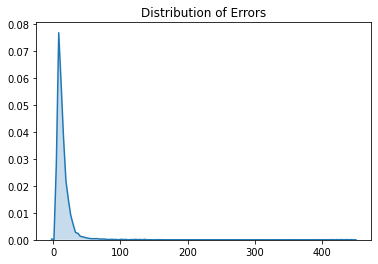

In [47]:
import seaborn as sb
sb.kdeplot(errors, shade=True)
plt.title("Distribution of Errors")


If the errors for each value of the data set were normally distributed, we can consider all values away that are beyond 1 standard deviation from the mean as anomaly. Hence, we are now fitting this data to a normal distribution.

In [48]:
from scipy.stats import norm
params = norm.fit(errors)
dist = norm(loc=params[0], scale=params[1])

dist.mean(), dist.std()

(14.516582349189243, 15.687981174542685)

We get the mean and standard deviation here. We can consider all the values that lie around 1 standard deviation away from the mean. Any value beyond this can be considered an anomaly. We can consider different ranges of error beyond which a value can be anomaly. We have chosen a range of 1 standard deviation from the mean to consider a value normal.

In [49]:
def is_anomaly(error, mean, std, threshold):
    difference = np.abs(error - mean)
    value = difference / std
    if value < threshold:
        return 0
    else:
        return 1

In [50]:
y_val_pred = model.predict(X_val[:, :, :])
val_errors = [mean_absolute_error(y_val[i, :], y_val_pred[i, :]) for i in range(y_val_pred.shape[0])]
results = [is_anomaly(x, dist.mean(), dist.std(), 1) for x in val_errors]
print(results)


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [51]:
# MSE
from sklearn.metrics import mean_squared_error
y_val_pred = model.predict(X_val[:, :, :])
# y_val = y_val.reshape(y_val.shape[0], y_val.shape[2])
mse = [mean_squared_error(y_val[i, :], y_val_pred[i, :]) for i in range(y_val_pred.shape[0])]
results_mse = [is_anomaly(x, mean(mse), stdev(mse), 1) for x in mse]
print(results_mse)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [52]:
# R2 Score
from sklearn.metrics import r2_score
y_val_pred = model.predict(X_val[:, :, :])
# y_val = y_val.reshape(y_val.shape[0], y_val.shape[2])
r2 = [r2_score(y_val[i, :], y_val_pred[i, :]) for i in range(y_val_pred.shape[0])]
results_r2 = [is_anomaly(x, mean(r2), stdev(r2), 1) for x in r2]
print(results_r2)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [53]:
def anomaly_score(error, dist):
    delta = np.abs(error - dist.mean())
    return dist.cdf(dist.mean() + delta)


result = [np.round(anomaly_score(x, dist), 4) for x in val_errors]
print(result)

[0.6656, 0.665, 0.7428, 0.7502, 0.7127, 0.6943, 0.6518, 0.6686, 0.7423, 0.757, 0.7455, 0.6772, 0.6086, 0.6465, 0.5498, 0.5181, 0.5357, 0.5426, 0.5733, 0.6344, 0.6754, 0.5285, 0.5144, 0.5755, 0.5747, 0.6739, 0.6397, 0.6187, 0.5594, 0.6798, 0.7001, 0.7487, 0.8185, 0.7838, 0.7208, 0.5902, 0.7336, 0.7688, 0.8015, 0.8032, 0.8503, 0.8002, 0.6902, 0.5271, 0.6088, 0.7011, 0.7833, 0.7743, 0.7771, 0.7536, 0.7433, 0.6748, 0.683, 0.6901, 0.6833, 0.6147, 0.5841, 0.5111, 0.5034, 0.511, 0.5137, 0.5657, 0.6402, 0.7231, 0.6645, 0.6069, 0.5266, 0.5327, 0.5323, 0.5231, 0.5047, 0.6678, 0.6274, 0.6309, 0.6384, 0.6783, 0.6606, 0.7348, 0.7382, 0.7465, 0.7093, 0.7505, 0.7404, 0.7076, 0.6716, 0.6969, 0.7046, 0.6588, 0.6801, 0.7089, 0.7031, 0.6898, 0.7468, 0.7257, 0.695, 0.7115, 0.7183, 0.7102, 0.7167, 0.7637, 0.7607, 0.7751, 0.777, 0.755, 0.778, 0.7795, 0.7214, 0.6761, 0.6444, 0.5969, 0.5265, 0.5842, 0.6452, 0.6856, 0.7176, 0.7659, 0.7813, 0.7376, 0.7482, 0.7356, 0.6828, 0.6583, 0.6522, 0.5803, 0.5534, 0.5546,

In [54]:
f = []
for i in range(len(y_val)):
  f.append(y_val[i][0])


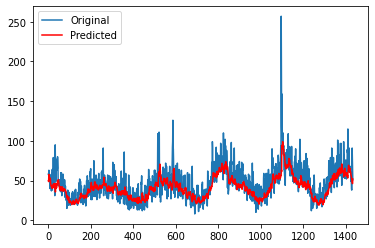

In [55]:
import matplotlib.pyplot as plt

plt.plot(y_val[:,0], label="Original")
plt.plot(y_val_pred[:,0],color="r", label="Predicted")
plt.legend()

In [56]:
# For MAE plot
plot_x=[]
plot_y=[]
for i in range(len(results)): 
  if results[i] == 1:
    plot_x.append(i)
    plot_y.append(y_val[i][0])
print(plot_y)

[array([77]), array([37]), array([32]), array([64]), array([109]), array([95]), array([51]), array([45]), array([47]), array([59]), array([76]), array([92]), array([99]), array([126]), array([55]), array([73]), array([66]), array([69]), array([58]), array([59]), array([86]), array([67]), array([78]), array([94]), array([73]), array([257]), array([164]), array([118]), array([65]), array([60]), array([53]), array([89]), array([102]), array([56]), array([89]), array([85]), array([85])]


Text(0.5, 1.0, 'MAE Error Metric')

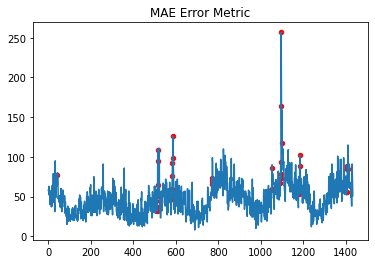

In [57]:
plt.plot(y_val[:,0].squeeze())
plt.scatter(plot_x,plot_y, color="r",s=20)
plt.title("MAE Error Metric")


In [58]:
# For MSE plot
plot_x=[]
plot_y=[]
for i in range(len(results_mse)): 
  if results_mse[i] == 1:
    plot_x.append(i)
    plot_y.append(y_val[i][0])
print(plot_y)

[array([77]), array([37]), array([32]), array([64]), array([109]), array([95]), array([51]), array([45]), array([47]), array([59]), array([76]), array([92]), array([99]), array([126]), array([55]), array([73]), array([66]), array([69]), array([58]), array([59]), array([86]), array([67]), array([78]), array([94]), array([73]), array([257]), array([164]), array([118]), array([65]), array([60]), array([53]), array([89]), array([102]), array([56]), array([89]), array([85]), array([85])]


Text(0.5, 1.0, 'MSE Error Metric')

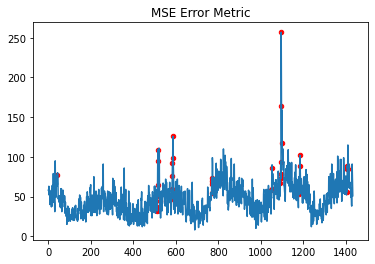

In [59]:
plt.plot(y_val[:,0].squeeze())
plt.scatter(plot_x,plot_y, color="r",s=20)
plt.title("MSE Error Metric")

[array([77]), array([37]), array([32]), array([64]), array([109]), array([95]), array([51]), array([45]), array([47]), array([59]), array([76]), array([92]), array([99]), array([126]), array([55]), array([73]), array([66]), array([69]), array([58]), array([59]), array([86]), array([67]), array([78]), array([94]), array([73]), array([257]), array([164]), array([118]), array([65]), array([60]), array([53]), array([89]), array([102]), array([56]), array([89]), array([85]), array([85])]


Text(0.5, 1.0, 'R2 Score Metric')

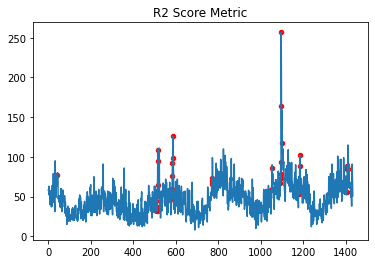

In [60]:
# For R2 plot
plot_x=[]
plot_y=[]
for i in range(len(results_r2)): 
  if results_r2[i] == 1:
    plot_x.append(i)
    plot_y.append(y_val[i][0])
print(plot_y)

plt.plot(y_val[:,0].squeeze())
plt.scatter(plot_x,plot_y, color="r", s=20)
plt.title("R2 Score Metric")

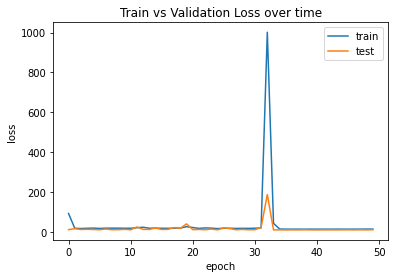

In [61]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Train vs Validation Loss over time')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='best')